Stroke risk prediction dataset using machine learning

Introduction
This project aims to predict the risk of stroke in individuals using machine learning techniques. By leveraging a combination of demographic, lifestyle, and health-related features, the model provides insights that could assist healthcare professionals in early detection and prevention strategies.

Dataset
The dataset used in this project is publicly available and contains information about patients' demographics, medical history, and lifestyle choices. It can be found at:

https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download

Note: The dataset is imbalanced, with a small percentage of patients having experienced a stroke. It is also a small dataset.

After running the script, you will obtain:

Best Parameters for each model after hyperparameter tuning.
Classification Report: Precision, Recall, F1-Score for each class.
Confusion Matrix: Visual representation of the model's performance.
ROC-AUC Curve: Plot showing the trade-off between True Positive Rate and False Positive Rate.

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv("C:/NHS maternity data/discharge files processed/healthcare-dataset-stroke-data.csv")

#Show dataset has loaded, search for missing values
print(data.head())
print("\nMissing values per column:")
print(data.isnull().sum())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

Missing values per column:
id                     0
gen

In [53]:
# Impute missing values in 'bmi' with mean
data['bmi'].fillna(data['bmi'].mean(), inplace=True)
print(data.isnull().sum())


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [54]:
# Encode categorical variables
le = LabelEncoder()
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for feature in categorical_features:
    data[feature] = le.fit_transform(data[feature])


In [55]:
# Drop 'id' column
data.drop('id', axis=1, inplace=True)

In [56]:
# Define features and target variable
X = data.drop('stroke', axis=1)
y = data['stroke']


In [57]:
# Handle imbalanced dataset using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [58]:
# Split data into training, validation, and testing sets (60% train, 20% validation, 20% test)
X_train_full, X_test, y_train_full, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)


In [59]:
# Feature Scaling
scaler = StandardScaler()
numerical_features = ['age', 'avg_glucose_level', 'bmi']

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


In [60]:
# Initialize models
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

In [61]:
# Hyperparameter tuning for Random Forest using Stratified K-Fold Cross-Validation
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=skf, n_jobs=-1, scoring='roc_auc')
grid_rf.fit(X_train, y_train)
print("\nBest parameters for Random Forest:")
print(grid_rf.best_params_)


Best parameters for Random Forest:
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [62]:
# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5]
}
grid_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=skf, n_jobs=-1, scoring='roc_auc')
grid_gb.fit(X_train, y_train)
print("\nBest parameters for Gradient Boosting:")
print(grid_gb.best_params_)


Best parameters for Gradient Boosting:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [63]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5]
    }
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=skf, n_jobs=-1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)
print("\nBest parameters for XGBoost:")
print(grid_xgb.best_params_)


Best parameters for XGBoost:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


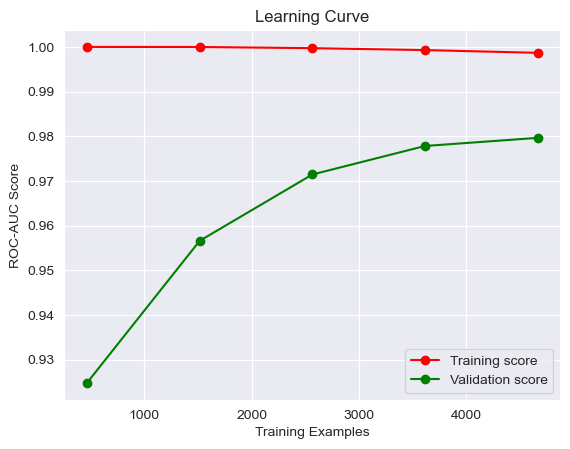

In [64]:
# Ensemble Model using Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', grid_rf.best_estimator_),
        ('gb', grid_gb.best_estimator_),
        ('xgb', grid_xgb.best_estimator_)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=voting_clf,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('ROC-AUC Score')
plt.legend(loc='best')
plt.show()

In [65]:
y_val_pred = voting_clf.predict(X_val)
y_val_proba = voting_clf.predict_proba(X_val)[:,1]

In [66]:
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))


Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       973
           1       0.91      0.95      0.93       972

    accuracy                           0.92      1945
   macro avg       0.92      0.92      0.92      1945
weighted avg       0.92      0.92      0.92      1945



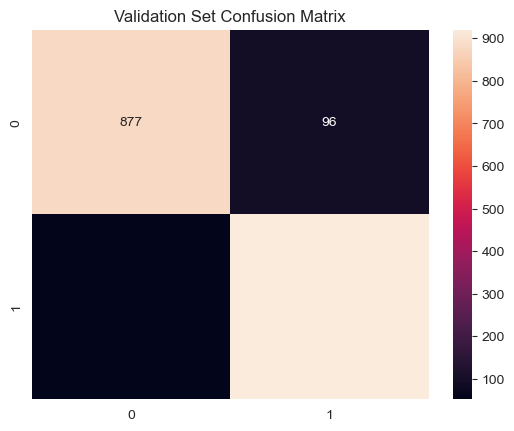

In [67]:
# Confusion Matrix
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d')
plt.title('Validation Set Confusion Matrix')
plt.show()

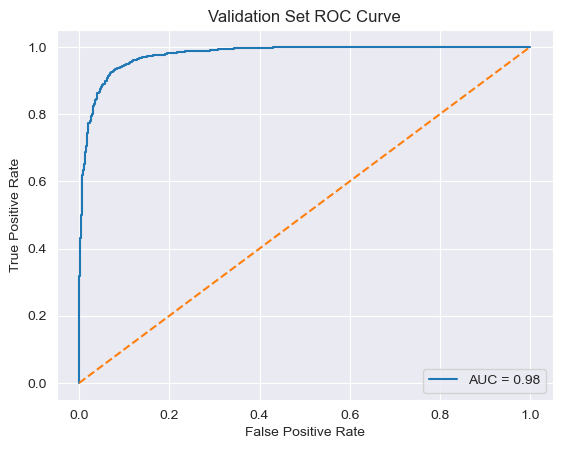

In [68]:
# ROC-AUC Curve
roc_auc_val = roc_auc_score(y_val, y_val_proba)
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_proba)
plt.plot(fpr_val, tpr_val, label='AUC = %.2f' % roc_auc_val)
plt.plot([0,1], [0,1], linestyle='--')
plt.title('Validation Set ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

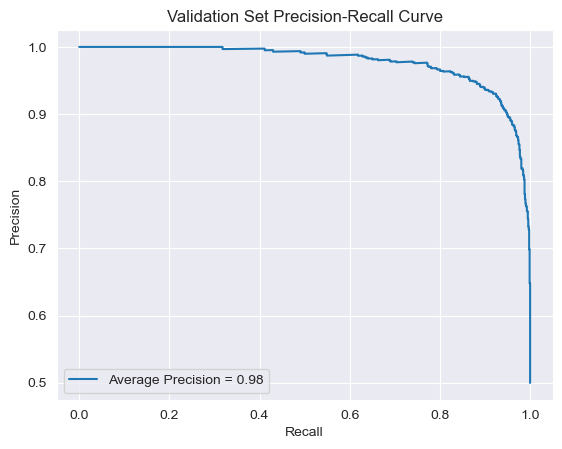

In [69]:
# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_val, y_val_proba)
average_precision = average_precision_score(y_val, y_val_proba)
plt.plot(recall, precision, label='Average Precision = %.2f' % average_precision)
plt.title('Validation Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [70]:
# Get feature importances from the Random Forest model
feature_importances = grid_rf.best_estimator_.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

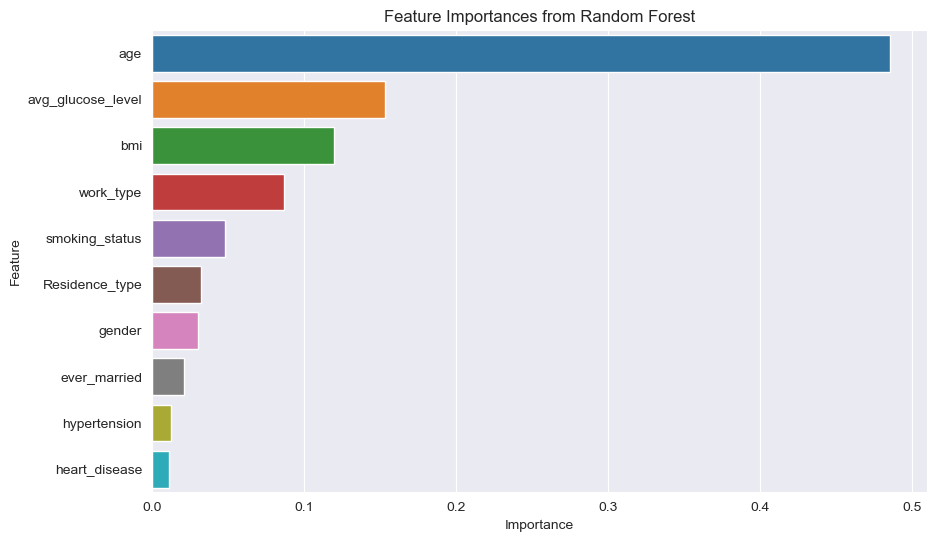

In [71]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()

In [72]:
y_test_pred = voting_clf.predict(X_test)
y_test_proba = voting_clf.predict_proba(X_test)[:,1]
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       975
           1       0.91      0.96      0.93       970

    accuracy                           0.93      1945
   macro avg       0.93      0.93      0.93      1945
weighted avg       0.93      0.93      0.93      1945



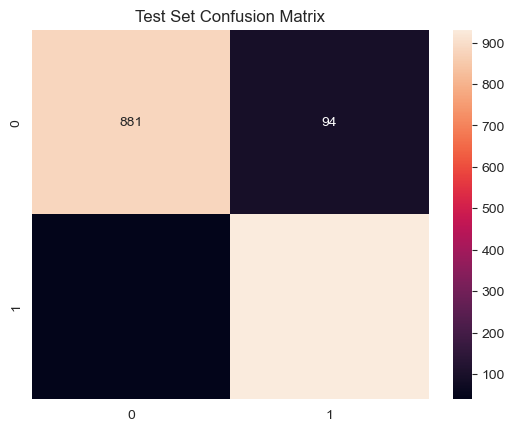

In [73]:
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.title('Test Set Confusion Matrix')
plt.show()

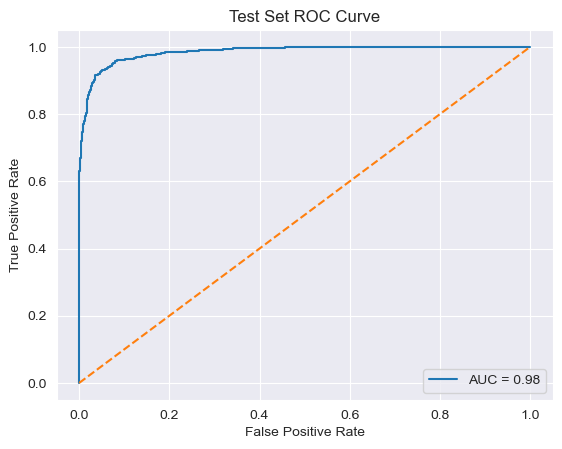

In [74]:
roc_auc_test = roc_auc_score(y_test, y_test_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
plt.plot(fpr_test, tpr_test, label='AUC = %.2f' % roc_auc_test)
plt.plot([0,1], [0,1], linestyle='--')
plt.title('Test Set ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

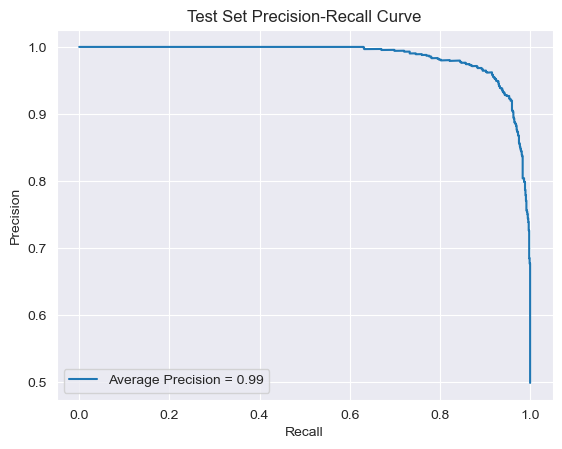

In [75]:
precision_test, recall_test, thresholds_pr_test = precision_recall_curve(y_test, y_test_proba)
average_precision_test = average_precision_score(y_test, y_test_proba)
plt.plot(recall_test, precision_test, label='Average Precision = %.2f' % average_precision_test)
plt.title('Test Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()